# Q2-Maximum Likelihood Gaussians per killer

In [ ]:
import pandas as pd
from scipy.stats import multivariate_normal
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Ellipse

path=r"C:\Unipi-CS\5ο εξάμηνο\Αναγνώριση Προτύπων\project\Data\original dataset\crimes.csv"

data=pd.read_csv(path)

In [22]:
def plot_killer_ellipses(full_dataset, results, feat_x="latitude", feat_y="longitude"):
    train_data = full_dataset[full_dataset["split"] == "TRAIN"]
    features = ["hour_float", "victim_age", "latitude", "longitude","temp_c","humidity","dist_precinct_km","pop_density"]
    
    
    idx_x = features.index(feat_x)
    idx_y = features.index(feat_y)
    
    plt.figure(figsize=(10, 8))
    
    for killer_id, profile in results.items():
        temp = train_data[train_data["killer_id"] == killer_id]
        X_2d = temp[[feat_x, feat_y]].values
        
        if len(X_2d) < 2: continue 
        
        mu_full = np.array(profile["mean"])
        sigma_full = np.array(profile["sigma"])
        
        mu_2d = mu_full[[idx_x, idx_y]]
        sigma_2d = sigma_full[np.ix_([idx_x, idx_y], [idx_x, idx_y])]
        
        sigma_2d += np.eye(2) * 1e-9
        
        inv_sigma = np.linalg.inv(sigma_2d)
        d2_distances = []
        for x in X_2d:
            diff = x - mu_2d
            d2 = diff.T @ inv_sigma @ diff
            d2_distances.append(d2)
        
        ck = max(d2_distances)
        
        vals, vecs = np.linalg.eigh(sigma_2d)
        order = vals.argsort()[::-1]
        vals, vecs = vals[order], vecs[:, order]
        
        
        theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
        
        width, height = 2 * np.sqrt(vals * ck)
        
        ax = plt.gca()
        ell = Ellipse(xy=mu_2d, width=width, height=height, angle=theta, 
                      edgecolor='red', fc='None', lw=2, alpha=0.6)
        ax.add_patch(ell)
        plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10, label=f'Killer {killer_id}')

    plt.xlabel(feat_x)
    plt.ylabel(feat_y)
    plt.title(f"Ellipses containing all TRAIN points ({feat_x} vs {feat_y})")
    plt.show()


In [23]:
def visualize_killers(results):
    features =["hour_float", "victim_age", "latitude", "longitude","temp_c","humidity","dist_precinct_km","pop_density"]
    for killer_id, data in results.items():
        sigma = data["sigma"]
        
        df_sigma = pd.DataFrame(sigma, index=features, columns=features)
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(df_sigma, annot=True, cmap='RdBu_r', center=0)
        plt.title(f"Covariance Matrix Heatmap - Killer {killer_id}")
        plt.show()
 

In [24]:
train_dataset=data[data["split"]=="TRAIN"]


--- Verification for Killer 3 ---
Scipy Log-Likelihood: -11143.87296281931
Διαφορά Mean: 1.3339329640871256e-13
Διαφορά Sigma: 6.528911525999215e-13


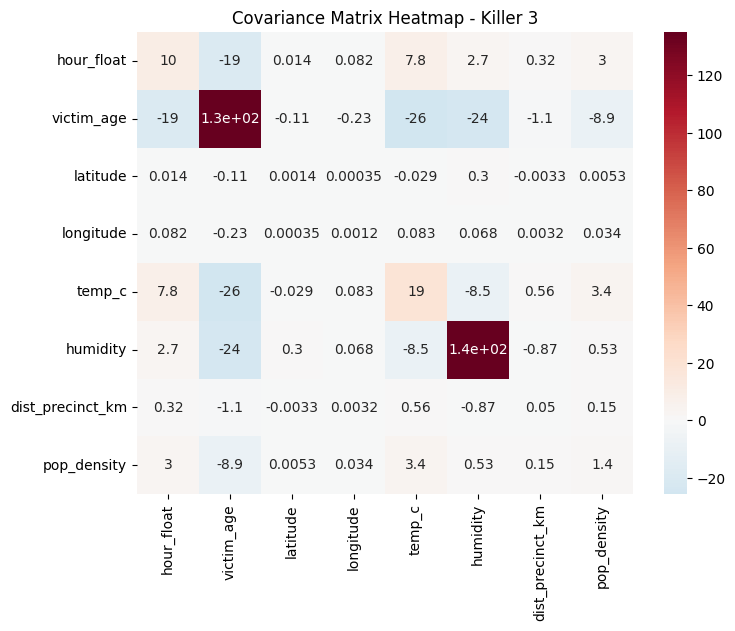

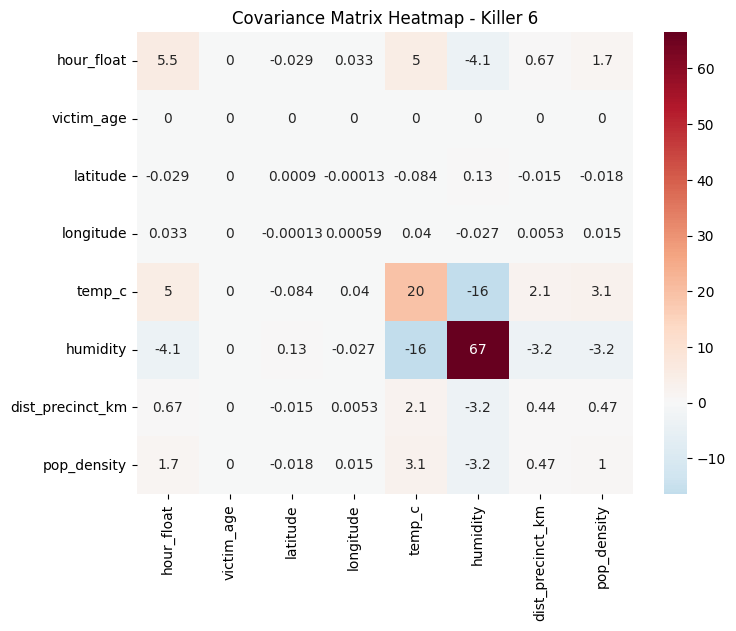

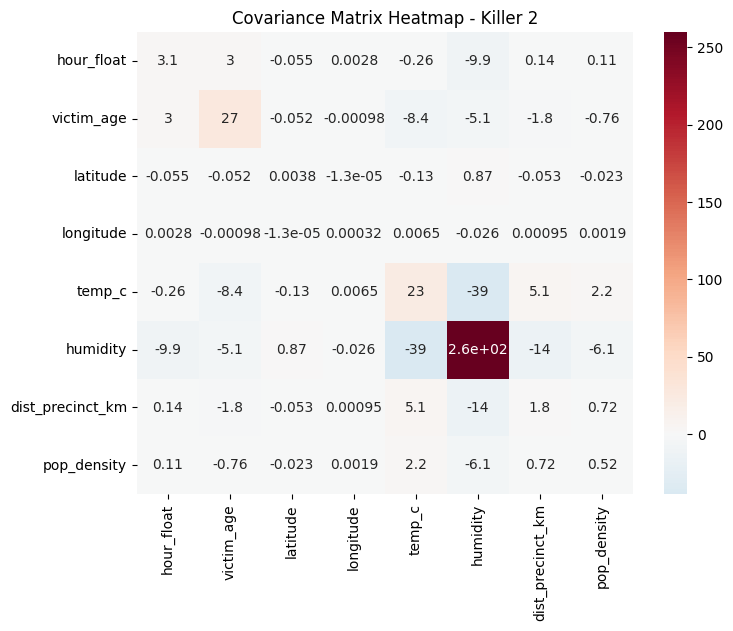

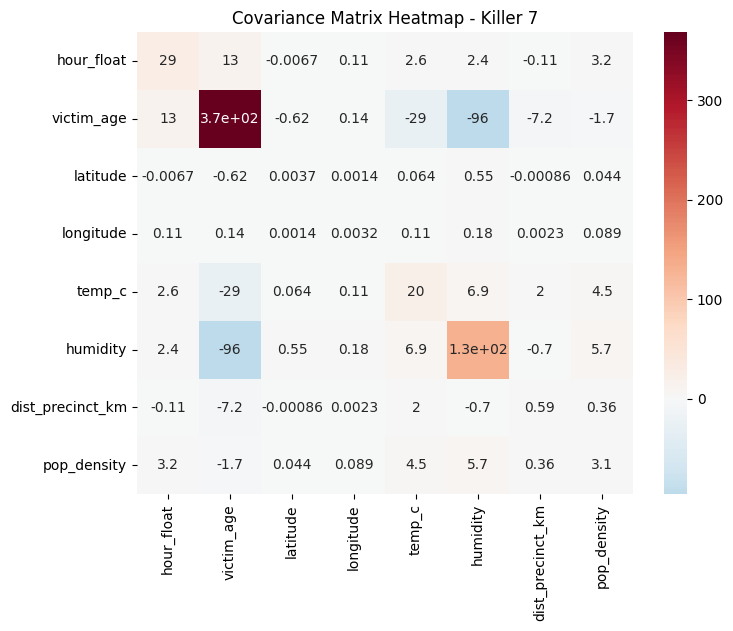

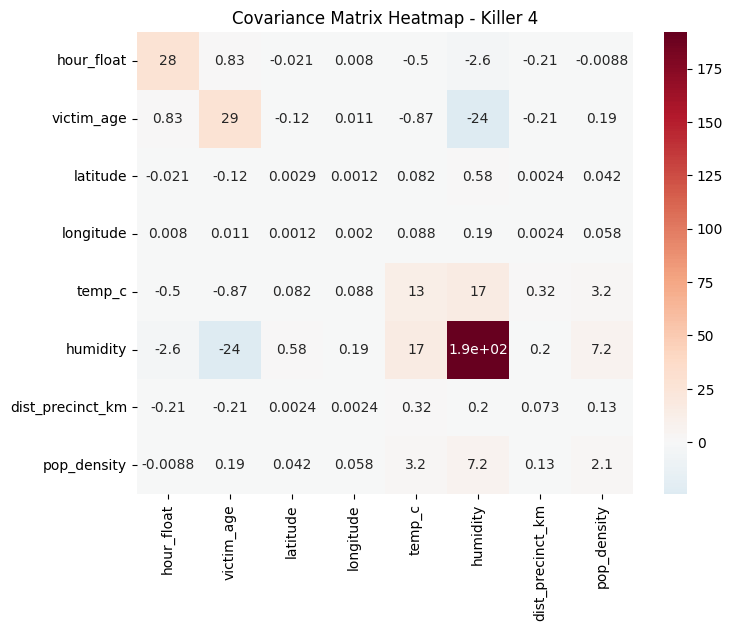

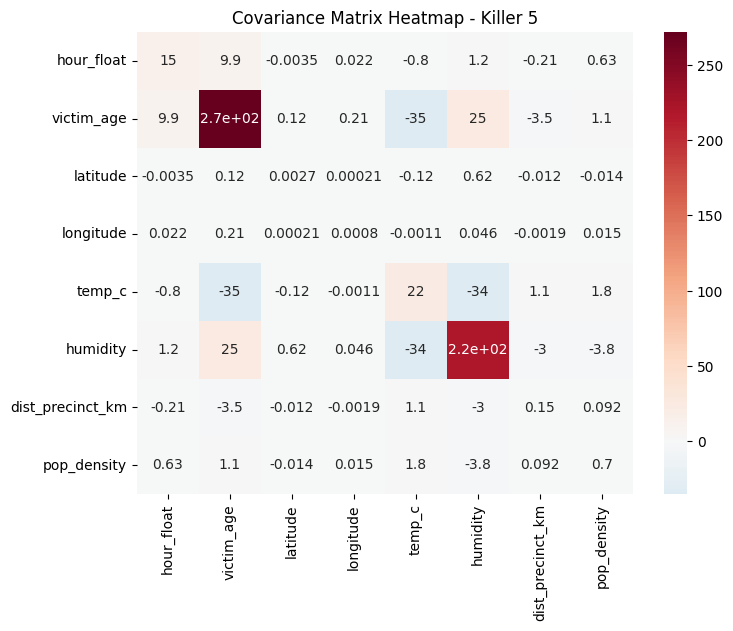

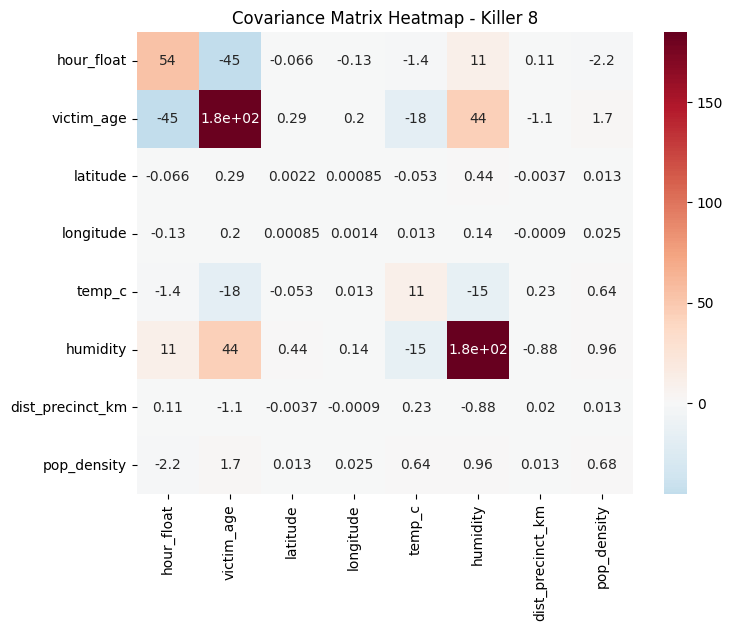

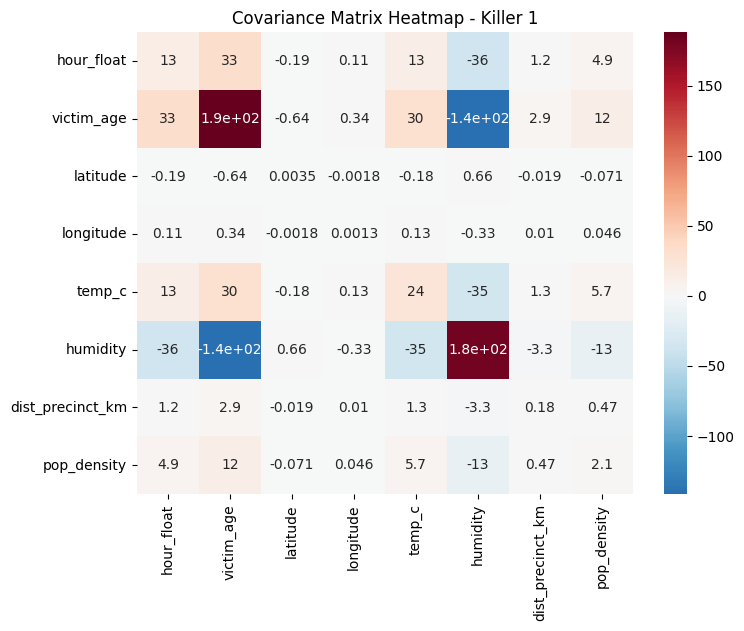

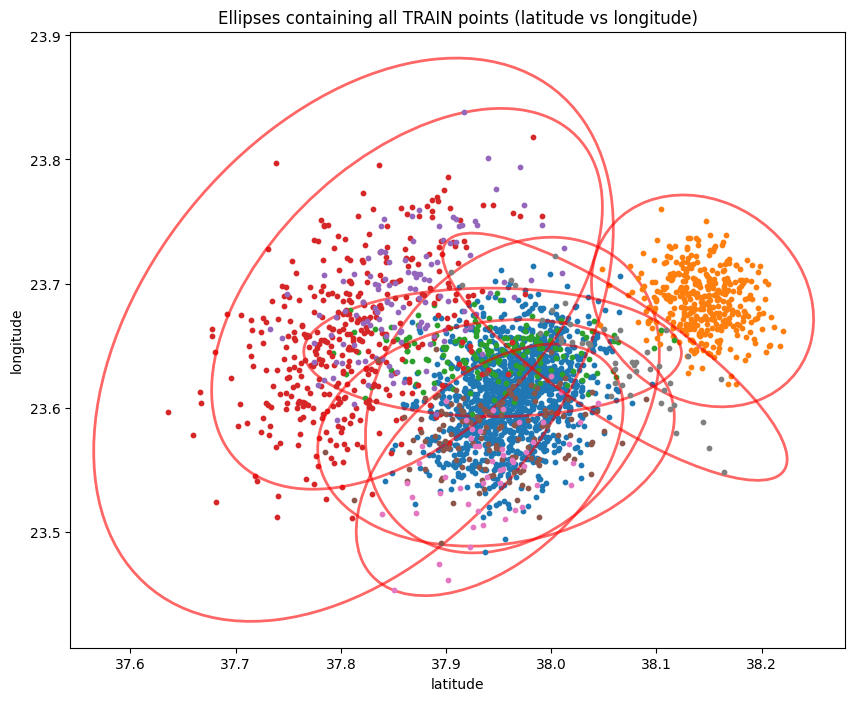

In [25]:
results = {}

killers_id=train_dataset["killer_id"].unique()

for killer_id in killers_id:
        
        temp=train_dataset[train_dataset["killer_id"]==killer_id]
        features_q2=["hour_float", "victim_age", "latitude", "longitude","temp_c","humidity","dist_precinct_km","pop_density"]
        
        
        mean_lst=[]
        N=len(temp)
        
        for feature in features_q2:
            total=0
            for record in temp[feature]:
                total+=record
            mean=total/N
            mean_lst.append(mean)
            
        sigma_matrix=[[0,0,0,0,0,0,0,0] for _ in range(8)]
        
        records=temp[features_q2].values.tolist()
        for record in records:
            diffs=[]
            for i in range(8):
                diffs.append(record[i]-mean_lst[i])
            
            for i in range(8):
                for j in range(8):
                    sigma_matrix[i][j]+=diffs[i]*diffs[j]
                    
        for i in range(8):
                for j in range(8):
                    sigma_matrix[i][j]=sigma_matrix[i][j]/N
            
        results[killer_id]={
                "mean":mean_lst,
                "sigma":sigma_matrix
            }
        
test_killer=killers_id[0]
killer_data = train_dataset[(train_dataset["split"]=="TRAIN") & (train_dataset["killer_id"]==test_killer)]
X = killer_data[["hour_float", "victim_age", "latitude", "longitude","temp_c","humidity","dist_precinct_km","pop_density"]].values
    
my_mu = results[test_killer]["mean"]
my_sigma = results[test_killer]["sigma"]
    
scipy_log_likelihood = np.sum(multivariate_normal.logpdf(X, mean=my_mu, cov=my_sigma))

print(f"\n--- Verification for Killer {test_killer} ---")
print(f"Scipy Log-Likelihood: {scipy_log_likelihood}")
    
numpy_mu = np.mean(X, axis=0)
numpy_sigma = np.cov(X, rowvar=False, bias=True) 

print(f"Διαφορά Mean: {np.abs(my_mu - numpy_mu).sum()}")
print(f"Διαφορά Sigma: {np.abs(my_sigma - numpy_sigma).sum()}")
    
visualize_killers(results)
    
plot_killer_ellipses(train_dataset, results, "latitude", "longitude")   
        


    